### Set up Data and Import Libraries

In [9]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set(style="darkgrid")

In [10]:
#Define df as our Dataset and set date as our index for the Dataset
df = pd.read_csv("data_clean_with_dummies.csv")
df = df.set_index('date')

#Define X and y, with X holding the Features and y the correspoding Count of pedestrians
#Features with PCA k=0.999 (PC1 - PC48)
X = df[df.columns[55:103]]

# The targetvariable we try to predict is the pedestrian count
y = df["pedestrians count"]

In [11]:
from sklearn.model_selection import train_test_split

# Split the dataset into train and test sets as numpy arryas (for our Neural Network)
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y, test_size=0.3, random_state=72)


from sklearn.preprocessing import StandardScaler
#Normalize the Data
# Scale the inputs to standardize the values of the Features
scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.fit_transform(Xtest)

### Visualize the Data 

### Baseline Model with Tensorflow

In [12]:
from tensorflow import keras
from tensorflow.keras import layers

In [13]:
#Define Neural Network model

#Create a Keras Sequential class to hold the different layers of our Neural Network
model = keras.Sequential()

model.add(keras.Input(shape=X.shape[1])) #Add a Input layer and define the Input shape of it (which is the column lenght of the feature Dataset X)
model.add(layers.Dense(100, activation="relu")) #Add a Hidden layer with 500 Neurones with Dense. Dense takes the output from our Input layer applies a weight matrix and than applies a activation function (in this case relu).
model.add(layers.Dense(50, activation="relu")) #Add a second Hidden layer with 250 Neurones with Dense. Dense takes the output from our first hidden layer applies a weight matrix and than applies a activation function (in this case relu).
model.add(layers.Dense(50, activation="relu")) #Add a third Hidden layer with 100 Neurones with Dense. 
model.add(layers.Dense(50, activation="relu")) #Add a third Hidden layer with 100 Neurones with Dense. 
model.add(layers.Dense(25, activation="relu")) #Add a fourth Hidden layer with 50 Neurones with Dense. 
model.add(layers.Dense(10, activation="relu")) #Add a fourth Hidden layer with 50 Neurones with Dense. 
model.add(layers.Dense(1, activation="relu")) # Add a output layer with 1 Neuron because we only have one output --> predicted pedestrian count

model.summary()#Display an overview of the Model


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               4900      
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 50)                2550      
                                                                 
 dense_3 (Dense)             (None, 50)                2550      
                                                                 
 dense_4 (Dense)             (None, 25)                1275      
                                                                 
 dense_5 (Dense)             (None, 10)                260       
                                              

2022-11-25 12:39:30.035602: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-25 12:39:30.036305: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [14]:
#Specify the training configuration for the Neural Network
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),  # Optimizer that minimizes our loss function (f.e SGD or Adam) with a learning rate of 0.001
    loss=keras.losses.mae,  # Loss function to minimize --> Mean absolute error 
    metrics=["mae", "mse"], # List of metrics to monitor
)

#Mehrere callbacks einfügen mit learning rate von keras callbacks --> webseite
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=10)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_mae', factor=0.2,
                              patience=5, min_lr=0.00001)
callbacks_list = [stop_early,reduce_lr]



history = model.fit(
    Xtrain, # Fit the model on the train data 
    ytrain, #Fit the model on the train data 
    #batch_size=64,
    epochs=200, # 1 epoch is one training iteration - for each epoch the Neural Network processes the entire training data 
    callbacks = callbacks_list, #Stop training when training is no longer improving Mean absolute error of the validation data (20% of the training data) within 3 epochs (metrics)
    validation_split=0.2, #Reserve 20% of the training data for validation at the end of each epoch 
)

Epoch 1/200


2022-11-25 12:39:45.568396: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-25 12:39:46.009554: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


269/269 [==============================] - ETA: 0s - loss: 929.4022 - mae: 929.4022 - mse: 3187747.5000

2022-11-25 12:39:48.874656: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


269/269 [==============================] - 4s 11ms/step - loss: 929.4022 - mae: 929.4022 - mse: 3187747.5000 - val_loss: 591.0280 - val_mae: 591.0280 - val_mse: 1403752.7500 - lr: 0.0100
Epoch 2/200
269/269 [==============================] - 3s 10ms/step - loss: 560.0941 - mae: 560.0941 - mse: 1280024.0000 - val_loss: 444.7001 - val_mae: 444.7001 - val_mse: 913832.0000 - lr: 0.0100
Epoch 3/200
269/269 [==============================] - 3s 10ms/step - loss: 489.7209 - mae: 489.7209 - mse: 1056657.5000 - val_loss: 436.9078 - val_mae: 436.9078 - val_mse: 927004.8125 - lr: 0.0100
Epoch 4/200
269/269 [==============================] - 3s 11ms/step - loss: 445.8981 - mae: 445.8981 - mse: 909985.7500 - val_loss: 466.5365 - val_mae: 466.5365 - val_mse: 1001322.2500 - lr: 0.0100
Epoch 5/200
269/269 [==============================] - 3s 12ms/step - loss: 408.9375 - mae: 408.9375 - mse: 821752.6875 - val_loss: 403.5360 - val_mae: 403.5360 - val_mse: 819533.6250 - lr: 0.0100
Epoch 6/200
269/269 [=

### Model evaluation

In [15]:
# Evaluate the model on the test data using `evaluate` result is the corresponding MAE
print("Evaluate on test data")
results = model.evaluate(Xtest, ytest)
results_train = model.evaluate(Xtrain, ytrain)
print("test loss, test mae, test mse:", results)
print("train loss, train mae, train mse:", results_train)

Evaluate on test data
336/336 [==============================] - 2s 5ms/step - loss: 246.0871 - mae: 246.0871 - mse: 461593.7188
test loss, test mae, test mse: [292.29620361328125, 292.29620361328125, 447324.21875]
train loss, train mae, train mse: [246.0871124267578, 246.0871124267578, 461593.71875]


In [16]:
#Create a function that evaluates the model and saves the results in a dataframe 
def evaluate_model(model, Xtest, ytest):
    eval_dict = model.evaluate(Xtest, ytest, return_dict=True)
    
    display_df = pd.DataFrame([eval_dict.values()], columns=[list(eval_dict.keys())])
    
    return display_df

# Evaluate basemodel on test set and add results to dataframe
results_comparisson = evaluate_model(model, Xtest, ytest)

# Set index to 'Baseline'
results_comparisson.index = ['Startwerte']

# Display results
results_comparisson.head()

144/144 [==============================] - 1s 6ms/step - loss: 292.2962 - mae: 292.2962 - mse: 447324.2188


,loss,mae,mse
Startwerte,292.296204,292.296204,447324.21875


### Visualize the Model performance

 35/144 [======>.......................] - ETA: 0s

2022-11-25 12:45:04.508377: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


144/144 [==============================] - 1s 3ms/step


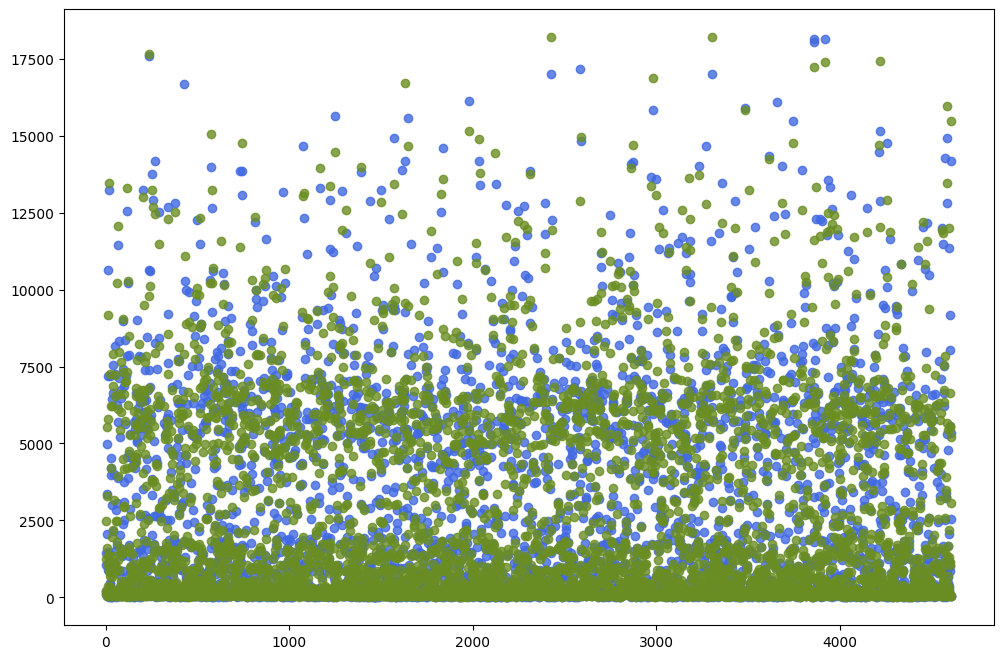

In [17]:
#Visualize the results predictions vs actual values
#Create a sequenze from 0 to the row lenght of the test data in order to plot
xs = np.linspace(0, ytest.shape[0], num=ytest.shape[0])

#Using the Neural Network to predict the Pedestrian count for our Xtest set in order to plot it against the actual values
ypred = model.predict(Xtest)


fig, ax = plt.subplots(figsize=(12, 8))

plt.scatter(xs, ytest, color ='royalblue', alpha=0.8)

plt.scatter(xs, ypred, color ='olivedrab', alpha=0.8)

plt.show()

144/144 [==============================] - 1s 8ms/step - loss: 292.2962 - mae: 292.2962 - mse: 447324.2188


Text(112.72222222222221, 0.5, 'MAE')

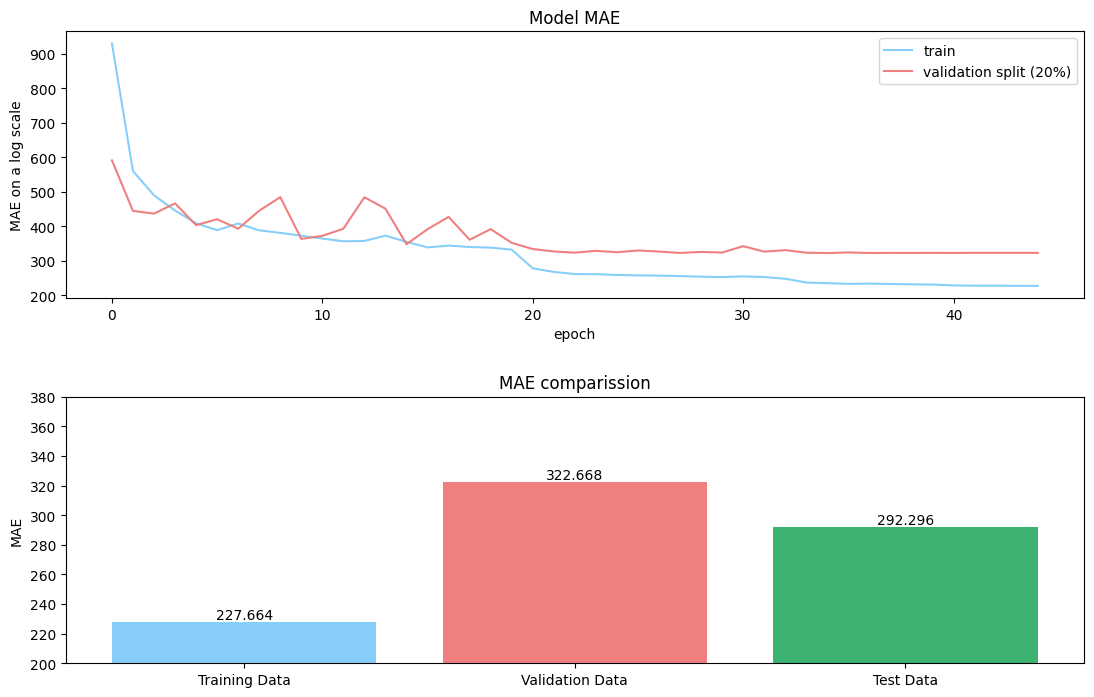

In [18]:
#Plot the MAE on the training data against the validation split of the Training data over time 
#history.history.keys()

fig, axs = plt.subplots(2, figsize=(12, 8))

fig.tight_layout(pad=5.0)

axs[0].plot(history.history['mae'], label="train", color="lightskyblue")
axs[0].plot(history.history['val_mae'], label="validation split (20%)", color="lightcoral")
axs[0].set_title('Model MAE')
axs[0].set_ylabel('MAE on a log scale')
axs[0].set_xlabel('epoch')
axs[0].legend(loc='upper right')
#axs[0].set_yscale("log")

f_mae = history.history["mae"]
f_val_mae = history.history["val_mae"]
f_test_mae = model.evaluate(Xtest, ytest)

axs[1].bar("Training Data",min(f_mae), color="lightskyblue") #Display minimum mae of the training data set
axs[1].bar("Validation Data", min(f_val_mae), color="lightcoral")#Display minimum mae of the validation data set
axs[1].bar("Test Data", f_test_mae[0], color="mediumseagreen")#Display mae of the test data set
axs[1].bar_label(axs[1].containers[0], label_type='edge')
axs[1].bar_label(axs[1].containers[1], label_type='edge')
axs[1].bar_label(axs[1].containers[2], label_type='edge')
axs[1].set_ylim([200, 380])
axs[1].set_title('MAE comparission')
axs[1].set_ylabel('MAE')


144/144 [==============================] - 1s 6ms/step - loss: 292.2962 - mae: 292.2962 - mse: 447324.2188


([<matplotlib.axis.XTick at 0x28006c220>,
 [Text(0.2, 0, 'Training Data'),
  Text(1.2, 0, 'Validation Data'),
  Text(2.2, 0, 'Test Data')])

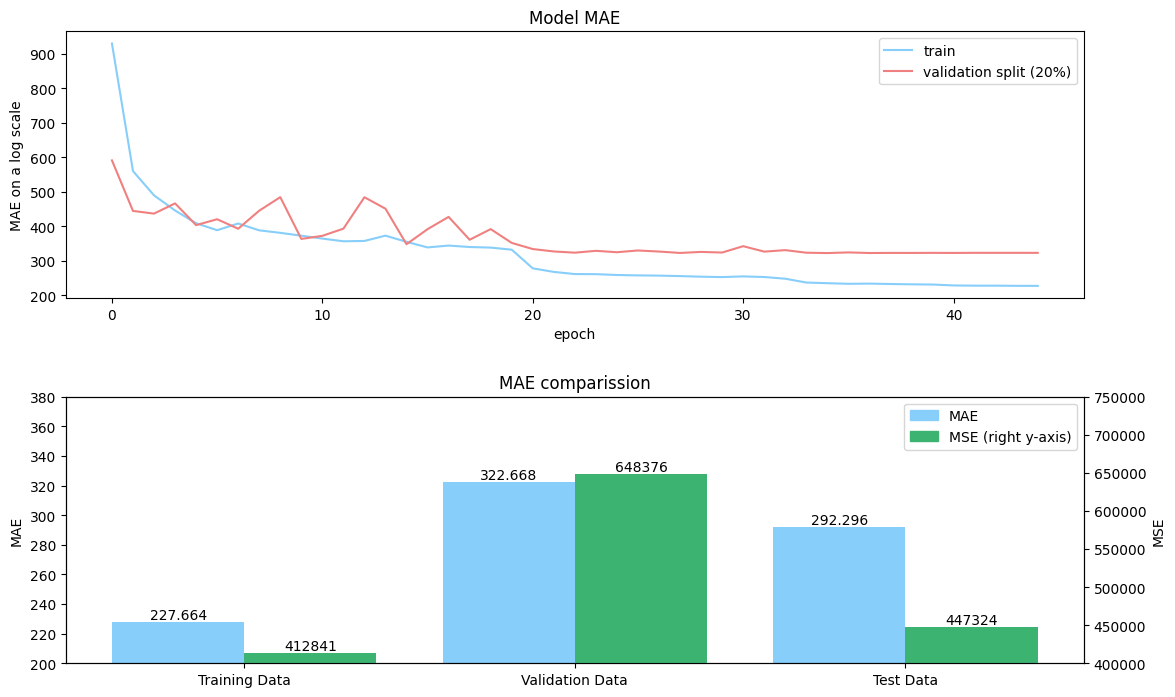

In [20]:
import matplotlib.patches as mpatches

#Plot the MAE on the training data against the validation split of the Training data over time 
#history.history.keys()

fig, axs = plt.subplots(2, figsize=(12, 8))

fig.tight_layout(pad=5.0)

axs[0].plot(history.history['mae'], label="train", color="lightskyblue")
axs[0].plot(history.history['val_mae'], label="validation split (20%)", color="lightcoral")
axs[0].set_title('Model MAE')
axs[0].set_ylabel('MAE on a log scale')
axs[0].set_xlabel('epoch')
axs[0].legend(loc='upper right')
#axs[0].set_yscale("log")

f_mae = history.history["mae"]
f_val_mae = history.history["val_mae"]
f_test_mae = model.evaluate(Xtest, ytest)


axs4 = axs[1].twinx()

x_axis = np.arange(3)

nameofdata = ["Training Data","Validation Data","Test Data"]

f_mse = history.history["mse"]
f_val_mse = history.history["val_mse"]


axs[1].bar(x_axis[0],min(f_mae), color="lightskyblue", width=0.4) #Display minimum mae of the training data set
axs[1].bar(x_axis[1], min(f_val_mae), color="lightskyblue", width=0.4)#Display minimum mae of the validation data set
axs[1].bar(x_axis[2], f_test_mae[0], color="lightskyblue", width=0.4)#Display mae of the test data set

axs[1].bar_label(axs[1].containers[0], label_type='edge')
axs[1].bar_label(axs[1].containers[1], label_type='edge')
axs[1].bar_label(axs[1].containers[2], label_type='edge')

axs[1].set_ylim([200, 380])
axs[1].set_title('MAE comparission')
axs[1].set_ylabel('MAE')


axs4.bar(x_axis[0] +0.4, min(f_mse), color="mediumseagreen", width=0.4)
axs4.bar(x_axis[1]+0.4, min(f_val_mse), color="mediumseagreen", width=0.4,)
axs4.bar(x_axis[2]+0.4, f_test_mae[2], color="mediumseagreen", width=0.4,)
axs4.set_ylabel('MSE')

axs4.bar_label(axs4.containers[0], label_type='edge')
axs4.bar_label(axs4.containers[1], label_type='edge')
axs4.bar_label(axs4.containers[2], label_type='edge')
axs4.set_ylim([400000, 750000])




#Custom Legend
leg_mae = mpatches.Patch(color='lightskyblue', label='MAE')
leg_mse = mpatches.Patch(color='mediumseagreen', label='MSE (right y-axis)')

axs[1].legend(handles=[leg_mae, leg_mse])

plt.xticks(x_axis + 0.2,nameofdata)

### Hyperparamter tuning 

In [46]:
import keras_tuner as kt

In [13]:
# def model_builder(hp): LEARNING RATE DECREASE implementieren
 
#     # Initialize sequential API and start building model.
#     model = keras.Sequential()
#     model.add(keras.layers.Flatten())
    
#     # Tune the number of hidden layers and units in each aswell as the best activation function.
#     # Number of hidden layers: 1 - 8
#     # Number of Units: 32 - 512 with stepsize of 32
#     for i in range(1, hp.Int("num_layers", 2, 7)):
        
#         hp_activation = hp.Choice('activation', values=['relu', 'tanh'])
        
#         model.add(
#             keras.layers.Dense(
#                 units=hp.Int("units_" + str(i), min_value=32, max_value=512, step=32),
#                 activation=hp_activation)
#             )
        
      
#     # Add output layer.
#     model.add(keras.layers.Dense(units=1, activation="relu"))
    
#     # Tune learning rate for Adam optimizer with values from 0.01, 0.001, or 0.0001
#     hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
    
#     # Define optimizer, loss, and metrics
#     model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
#                   loss=keras.losses.mae,
#                   metrics=["mae"])
    
#     return model


#### Tuning Optimzer, learning rate and activation function
##### This approach is used to reduce the computing time. A better way would be to build a larger model where the tuner would tune the optimizer, number of layers and number on nodes at the same time

In [129]:
#Find the best Optimizer on the baseline model 
def model_builder(hp): 
 
# Initialize sequential API and start building model.   
    model = keras.Sequential()

    hp_activation = hp.Choice('activation', values=['relu', 'tanh'])    

    model.add(keras.layers.Flatten()) #Add a Input layer and use flatten to get a 1 dimensional input!!!!
    model.add(layers.Dense(100, activation=hp_activation)) #Add a Hidden layer with 500 Neurones with Dense. Dense takes the output from our Input layer applies a weight matrix and than applies a activation function (in this case relu).
    model.add(layers.Dense(50, activation=hp_activation)) #Add a second Hidden layer with 250 Neurones with Dense. Dense takes the output from our first hidden layer applies a weight matrix and than applies a activation function (in this case relu).
    model.add(layers.Dense(50, activation=hp_activation)) #Add a third Hidden layer with 100 Neurones with Dense. 
    model.add(layers.Dense(50, activation=hp_activation)) #Add a third Hidden layer with 100 Neurones with Dense. 
    model.add(layers.Dense(25, activation=hp_activation)) #Add a fourth Hidden layer with 50 Neurones with Dense. 
    model.add(layers.Dense(10, activation=hp_activation)) #Add a fourth Hidden layer with 50 Neurones with Dense. 
    model.add(layers.Dense(1, activation=hp_activation))  #Add an output layer with activation function relu  

    #Tune learning rate 
    hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4, 1e-5])  # Tune learning rate with values 0.01, 0.001, 0.0001, 0.00001

    optimizers_dict = {
        "Adam":    keras.optimizers.Adam(learning_rate=hp_learning_rate),
        "SGD":     keras.optimizers.SGD(learning_rate=hp_learning_rate),
        "Adagrad": keras.optimizers.Adagrad(learning_rate=hp_learning_rate),
        "Adadelta": keras.optimizers.Adadelta(learning_rate=hp_learning_rate),
        "RMSprop": keras.optimizers.RMSprop(learning_rate=hp_learning_rate)
        }

    hp_optimizers = hp.Choice(
        'optimizer', 
        values=["Adam", "SGD", "Adagrad", "Adadelta", "RMSprop"]
        )


    model.compile(optimizer=optimizers_dict[hp_optimizers],
                  loss=keras.losses.mae,
                  metrics=["mae"])
    
    return model

In [133]:
#Easy tuner because we only have 5 different Optimizer options, 4 learning rate optimizations and 2 activation functions, so randomly selecting is okay because no matter what we will try every combination of the 40
tuner = kt.RandomSearch(hypermodel = model_builder,
                       objective = 'val_mae',
                       max_trials = 100,
                       executions_per_trial = 1,
                       directory = 'kt_dir',
                       overwrite=True,
                       project_name = 'kt_RandomSearch')

In [134]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=10)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_mae', factor=0.2,
                              patience=5, min_lr=0.000001)
callbacks_list = [stop_early,reduce_lr]

In [135]:
tuner.search(Xtrain, ytrain, epochs=25, validation_split=0.2, callbacks=callbacks_list)

Trial 4 Complete [00h 04m 17s]
val_mae: 651.4500732421875

Best val_mae So Far: 368.45184326171875
Total elapsed time: 00h 15m 30s

Search: Running Trial #5

Value             |Best Value So Far |Hyperparameter
tanh              |relu              |activation
1e-05             |0.01              |learning_rate
Adagrad           |Adadelta          |optimizer

Epoch 1/100


2022-11-25 16:48:31.034475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


269/269 [==============================] - ETA: 0s - loss: 2616.5547 - mae: 2616.5547

2022-11-25 16:48:35.325777: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


269/269 [==============================] - 6s 20ms/step - loss: 2616.5547 - mae: 2616.5547 - val_loss: 2605.5708 - val_mae: 2605.5708 - lr: 1.0000e-05
Epoch 2/100
269/269 [==============================] - 3s 12ms/step - loss: 2616.5518 - mae: 2616.5518 - val_loss: 2605.5664 - val_mae: 2605.5664 - lr: 1.0000e-05
Epoch 3/100
269/269 [==============================] - 5s 17ms/step - loss: 2616.5479 - mae: 2616.5479 - val_loss: 2605.5637 - val_mae: 2605.5637 - lr: 1.0000e-05
Epoch 4/100
269/269 [==============================] - 2s 8ms/step - loss: 2616.5447 - mae: 2616.5447 - val_loss: 2605.5603 - val_mae: 2605.5603 - lr: 1.0000e-05
Epoch 5/100
269/269 [==============================] - 2s 8ms/step - loss: 2616.5408 - mae: 2616.5408 - val_loss: 2605.5579 - val_mae: 2605.5579 - lr: 1.0000e-05
Epoch 6/100
269/269 [==============================] - 2s 8ms/step - loss: 2616.5391 - mae: 2616.5391 - val_loss: 2605.5562 - val_mae: 2605.5562 - lr: 1.0000e-05
Epoch 7/100
269/269 [================

KeyboardInterrupt: 

In [127]:
tuner.results_summary() #The best model used the RMSprop Optimizer 

Results summary
Results in kt_dir/kt_RandomSearch
Showing 10 best trials
Trial summary
Hyperparameters:
optimizer: RMSprop
Score: 323.7821350097656
Trial summary
Hyperparameters:
optimizer: Adam
Score: 340.6562805175781
Trial summary
Hyperparameters:
optimizer: Adagrad
Score: 371.4999694824219
Trial summary
Hyperparameters:
optimizer: Adadelta
Score: 385.860595703125
Trial summary
Hyperparameters:
optimizer: SGD
Score: 2554.15576171875


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
# Use the best Hyperparameter to build a new model and train the model on the training Dataset
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=15)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_mae', factor=0.2,
                              patience=5, min_lr=0.000001)
callbacks_list2 = [stop_early,reduce_lr]


#Hypertuned Model 
h1_model = tuner.hypermodel.build(best_hps)
#Create a new Hypertuned History to compare it with the Baseline Histroy 
h1_history = h1_model.fit(Xtrain, ytrain, epochs=150, validation_split=0.2,
                    callbacks=callbacks_list2)


In [ ]:
# Evaluate model on test set using the above created function to save the results in the results_comparisson dataframe
hyper_results1 = evaluate_model(h1_model, Xtest, ytest)

# Set index to hypertuned
hyper_results1.index = ["Baseline model Op/lr/af"]

# Append results in dataframe
results_comparisson = pd.concat([results_comparisson, hyper_results1])

results_comparisson.head()


#### Optimal number of layers and nodes

In [ ]:
def model_builder(hp): 
 
    # Initialize sequential API and start building model.
    model = keras.Sequential()
    model.add(keras.layers.Flatten())
    
    # Tune the number of hidden layers and units in each aswell as the best activation function.
    # Number of hidden layers: 8 - 12
    # Number of Units: 32 - 512 with stepsize of 32
    for i in range(1, hp.Int("num_layers", 8, 12)):

       #Find the bets activation function 
       #hp_activation = hp.Choice('activation', values=['relu', 'tanh'])
        
        model.add(
            keras.layers.Dense(
                units=hp.Int("units", min_value=32, max_value=512, step=32), # Find the best number of units (Nodes) betwenn 32 and 512 in 32 steps
                activation="relu")
            )
        
      
    # Add output layer.
    model.add(keras.layers.Dense(units=1, activation="relu"))
    
    #Here setting a learning rate is better/more efficient because other wise the Tuner would also have to tune the learning rate adding a huge amout of new models to try 
    
    # Define optimizer, loss, and metrics
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                  loss=keras.losses.mae,
                  metrics=["mae"])
    
    return model

In [ ]:
# Using the advanced Hyperband tuner which selects different Hyperparameter combinations when the have promising results after a few epochs and tunes them further
tuner = kt.Hyperband(model_builder,
                     objective='val_mae',
                     max_epochs=25,
                     factor=3,
                     hyperband_iterations=15,
                     overwrite=True,
                     directory='kt_dir',
                     project_name='kt_hyperband')

# Create a stop early function if val_mae doesn't improve over 3 epochs

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=10)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_mae', factor=0.2,
                              patience=5, min_lr=0.00001)
callbacks_list = [stop_early,reduce_lr]

In [ ]:
# Execute the tuner  
tuner.search(Xtrain, ytrain, epochs=25, validation_split=0.2, callbacks=callbacks_list)

In [ ]:
tuner.results_summary()

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
# Use the best Hyperparameter to build a new model and train the model on the training Dataset
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=15)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_mae', factor=0.2,
                              patience=5, min_lr=0.000001)
callbacks_list2 = [stop_early,reduce_lr]


#Hypertuned Model 
h2_model = tuner.hypermodel.build(best_hps)
#Create a new Hypertuned History to compare it with the Baseline Histroy 
h2_history = h2_model.fit(Xtrain, ytrain, epochs=150, validation_split=0.2,
                    callbacks=callbacks_list2)

In [ ]:
# Evaluate model on test set using the above created function to save the results in the results_comparisson dataframe
hyper_results2 = evaluate_model(h2_model, Xtest, ytest)

# Set index to hypertuned
hyper_results2.index = ["Baseline model Op/lr/af and NL/NN"]

# Append results in dataframe
results_comparisson = pd.concat([results_comparisson, hyper_results2])

results_comparisson.head()



### Complete Optimizer Model

In [96]:
def model_builder(hp): 
 
    # Initialize sequential API and start building model.
    model = keras.Sequential()
    model.add(keras.layers.Flatten())
    
    # Tune the number of hidden layers and units in each aswell as the best activation function.
    # Number of hidden layers: 6 - 12
    # Number of Units: 32 - 512 with stepsize of 32
    for i in range(1, hp.Int("num_layers", 6, 12)):

       #Find the bets activation function 
       hp_activation = hp.Choice('activation', values=['relu', 'tanh'])
        
        model.add(
            keras.layers.Dense(
                units=hp.Int("units", min_value=32, max_value=512, step=32), # Find the best number of units (Nodes) betwenn 32 and 512 in 32 steps
                activation=hp_activation)
            )
        
      
    # Add output layer.
    model.add(keras.layers.Dense(units=1, activation="relu"))


    #Tune learning rate

    #hp_learning_rate = hp.Float("lr", min_value=1e-5, max_value=1e-2, sampling="log") ##very time consuming
   
    hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4, 1e-5])  # Tune learning rate with values 0.01, 0.001, 0.0001, 0.00001
    
    #Tune optimal optimizer 

    optimizers_dict = {
        "Adam":    keras.optimizers.Adam(learning_rate=hp_learning_rate),
        "SGD":     keras.optimizers.SGD(learning_rate=hp_learning_rate),
        "Adagrad": keras.optimizers.Adagrad(learning_rate=hp_learning_rate),
        "Adadelta": keras.optimizers.Adadelta(learning_rate=hp_learning_rate),
        "RMSprop": keras.optimizers.RMSprop(learning_rate=hp_learning_rate)
        }

    hp_optimizers = hp.Choice(
        'optimizer', 
        values=["Adam", "SGD", "Adagrad", "Adadelta", "RMSprop"]
        )


    # Define optimizer, loss, and metrics
    model.compile(optimizer= optimizers_dict[hp_optimizers],
                  loss=keras.losses.mae,
                  metrics=["mae"])
    
    return model

In [72]:
# Create a tuner 
tuner = kt.Hyperband(model_builder,
                     objective='val_mae',
                     max_epochs=25,
                     factor=3,
                     hyperband_iterations=15,
                     overwrite=True,
                     directory='kt_dir',
                     project_name='kt_hyperband')

# Create a stop early function if val_mae doesn't improve over 3 epochs

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=10)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_mae', factor=0.2,
                              patience=5, min_lr=0.00001)
callbacks_list = [stop_early,reduce_lr]

In [73]:
# Execute the tuner  
tuner.search(Xtrain, ytrain, epochs=25, validation_split=0.2, callbacks=callbacks_list)

Trial 5 Complete [00h 00m 15s]
val_mae: 402.57183837890625

Best val_mae So Far: 402.57183837890625
Total elapsed time: 00h 01m 21s
INFO:tensorflow:Oracle triggered exit


In [66]:
tuner.results_summary()

Results summary
Results in kt_dir/kt_hyperband
Showing 10 best trials
Trial summary
Hyperparameters:
optimizer: RMSprop
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 436.24127197265625
Trial summary
Hyperparameters:
optimizer: Adam
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 487.08502197265625
Trial summary
Hyperparameters:
optimizer: Adagrad
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 532.9765625
Trial summary
Hyperparameters:
optimizer: Adadelta
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 721.5846557617188
Trial summary
Hyperparameters:
optimizer: SGD
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 2598.119384765625


### Further Hypertuning

In [115]:
# Save the best Hyperparameter the tuner has found 
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [116]:
# Use the best Hyperparameter to build a new model and train the model on the training Dataset
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=25) #high patience to try to improve even further with a very small learning rate
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_mae', factor=0.2,
                              patience=5, min_lr=0.000001)
callbacks_list2 = [stop_early,reduce_lr]


#Hypertuned Model 
h3_model = tuner.hypermodel.build(best_hps)
#Create a new Hypertuned History to compare it with the Baseline Histroy 
h3_history = h3_model.fit(Xtrain, ytrain, epochs=500, validation_split=0.2,
                    callbacks=callbacks_list2)


Epoch 1/500


2022-11-25 16:25:40.594016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


269/269 [==============================] - ETA: 0s - loss: 883.7388 - mae: 883.7388

2022-11-25 16:25:46.548659: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


269/269 [==============================] - 7s 21ms/step - loss: 883.7388 - mae: 883.7388 - val_loss: 538.2837 - val_mae: 538.2837 - lr: 0.0100
Epoch 2/500
269/269 [==============================] - 4s 14ms/step - loss: 623.0066 - mae: 623.0066 - val_loss: 693.4822 - val_mae: 693.4822 - lr: 0.0100
Epoch 3/500
269/269 [==============================] - 4s 13ms/step - loss: 574.4958 - mae: 574.4958 - val_loss: 557.4840 - val_mae: 557.4840 - lr: 0.0100
Epoch 4/500
269/269 [==============================] - 4s 16ms/step - loss: 519.4345 - mae: 519.4345 - val_loss: 508.6726 - val_mae: 508.6726 - lr: 0.0100
Epoch 5/500
269/269 [==============================] - 4s 15ms/step - loss: 497.4226 - mae: 497.4226 - val_loss: 422.6709 - val_mae: 422.6709 - lr: 0.0100
Epoch 6/500
269/269 [==============================] - 4s 15ms/step - loss: 482.1652 - mae: 482.1652 - val_loss: 441.3112 - val_mae: 441.3112 - lr: 0.0100
Epoch 7/500
269/269 [==============================] - 4s 14ms/step - loss: 463.59

In [117]:
# Evaluate model on test set using the above created function to save the results in the results_comparisson dataframe
hyper_results3 = evaluate_model(h3_model, Xtest, ytest)

# Set index to hypertuned
hyper_results3.index = ["Model with Hyperparametern tuned 'further'"]

# Append results in dataframe
results_comparisson = pd.concat([results_comparisson, hyper_results3])

results_comparisson.head()



144/144 [==============================] - 1s 5ms/step - loss: 295.8601 - mae: 295.8601


,loss,mae,mse
Startwerte,292.296204,292.296204,447324.21875
Hyperparameter,295.816101,295.816101,NaN
Hyperparameter,297.818268,297.818268,NaN
Hyperparameter,295.860077,295.860077,NaN


In [118]:
h3_model.summary()#Display an overview of the Model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 48)                0         
                                                                 
 dense_7 (Dense)             (None, 100)               4900      
                                                                 
 dense_8 (Dense)             (None, 50)                5050      
                                                                 
 dense_9 (Dense)             (None, 50)                2550      
                                                                 
 dense_10 (Dense)            (None, 50)                2550      
                                                                 
 dense_11 (Dense)            (None, 25)                1275      
                                                                 
 dense_12 (Dense)            (None, 10)               

### Evaluate and Viusalize the Hypertuned Model 

In [119]:
# Evaluate the model on the test data using `evaluate` result is the corresponding MAE
print("Evaluate on test data")
h3_results = h3_model.evaluate(Xtest, ytest)
h3_results_train = h3_model.evaluate(Xtrain, ytrain)
print("HP!! test loss, test mae, test mse:", h3_results)
print(" HP!!!! train loss, train mae, train mse:", h3_results_train)

Evaluate on test data
336/336 [==============================] - 3s 8ms/step - loss: 247.8339 - mae: 247.8339
HP!! test loss, test mae, test mse: [295.8600769042969, 295.8600769042969]
 HP!!!! train loss, train mae, train mse: [247.8339385986328, 247.8339385986328]


  8/144 [>.............................] - ETA: 0s 

2022-11-25 16:29:48.656757: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


144/144 [==============================] - 1s 4ms/step


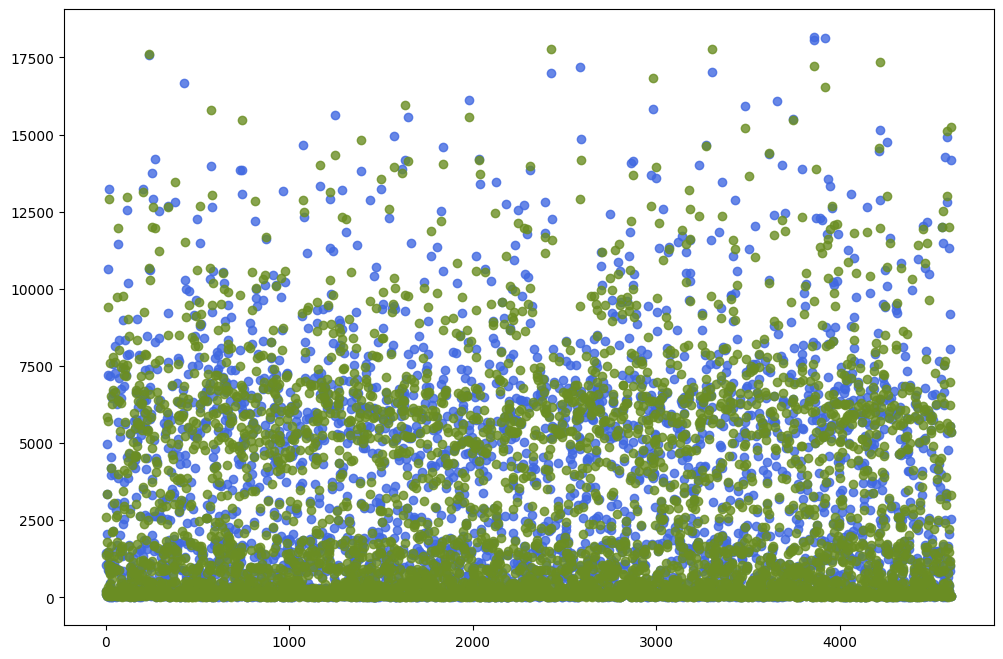

In [120]:
#Visualize the results predictions vs actual values
#Create a sequenze from 0 to the row lenght of the test data in order to plot
xs = np.linspace(0, ytest.shape[0], num=ytest.shape[0])

#Using the Neural Network to predict the Pedestrian count for our Xtest set in order to plot it against the actual values
yhpred = h_model.predict(Xtest)


fig, ax = plt.subplots(figsize=(12, 8))

plt.scatter(xs, ytest, color ='royalblue', alpha=0.8)

plt.scatter(xs, yhpred, color ='olivedrab', alpha=0.8)

plt.show()

2022-11-25 16:29:51.856008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


144/144 [==============================] - 1s 5ms/step - loss: 295.8601 - mae: 295.8601


Text(112.72222222222221, 0.5, 'MAE')

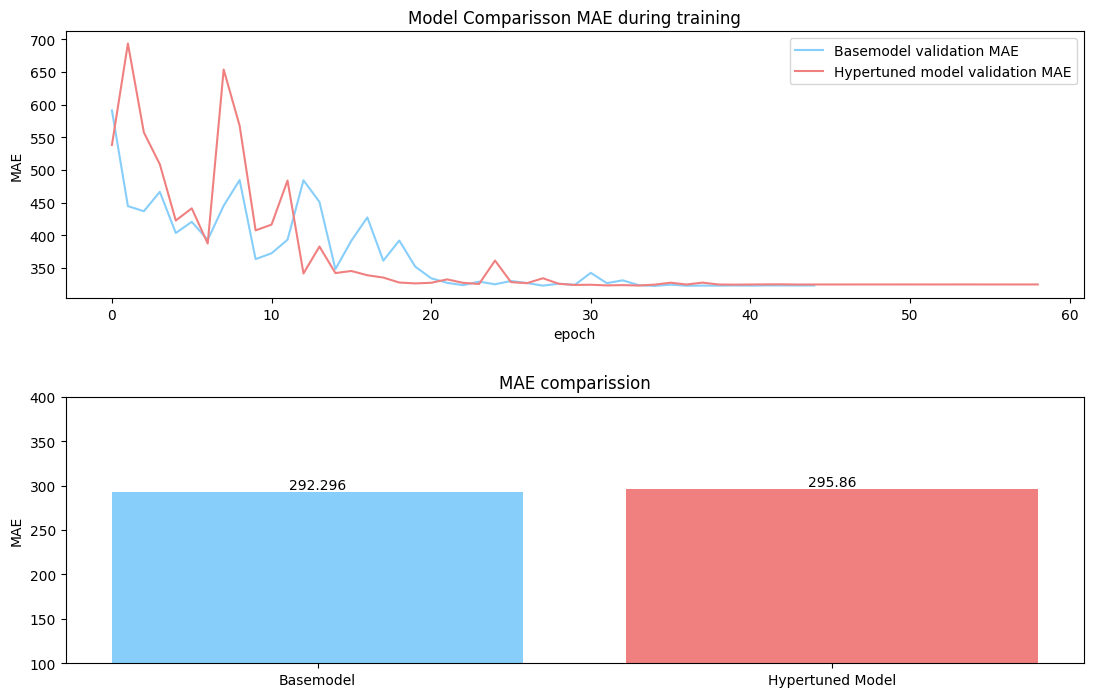

In [121]:
#Plot the MAE on the training data against the validation split of the Training data over time 
#history.history.keys()

fig, axs = plt.subplots(2, figsize=(12, 8))

fig.tight_layout(pad=5.0)

axs[0].plot(history.history['val_mae'], label="Basemodel validation MAE", color="lightskyblue")
axs[0].plot(h_history.history['val_mae'], label="Hypertuned model validation MAE", color="lightcoral")
axs[0].set_title('Model Comparisson MAE during training')
axs[0].set_ylabel('MAE')
axs[0].set_xlabel('epoch')
axs[0].legend(loc='upper right')


base_mae = model.evaluate(Xtest, ytest)
hp_mae = h_model.evaluate(Xtest, ytest)


axs[1].bar("Basemodel", base_mae[0], color="lightskyblue" )
axs[1].bar("Hypertuned Model", hp_mae[0], color="lightcoral")

axs[1].bar_label(axs[1].containers[0], label_type='edge')
axs[1].bar_label(axs[1].containers[1], label_type='edge')
axs[1].set_ylim([100, 400])
axs[1].set_title('MAE comparission')
axs[1].set_ylabel('MAE')